# Additive Secret Sharing

Recall the two-party summation protocol from the last chapter:

In [1]:
import pychor
p1 = pychor.Party('p1')
p2 = pychor.Party('p2')

with pychor.LocalBackend():
    # initialize the input values
    v1 = p1.constant(3)
    v2 = p2.constant(4)

    # Round 1: Each party sends their input to the other party
    v1.send(p1, p2)
    v2.send(p2, p1)

    # Round 2: Both parties sum the results and print them out
    total = v1 + v2
    print('Total sum:', total)

Total sum: 7@{p2, p1}


What if the parties don't trust each other? In this protocol, both parties completely reveal their inputs. If the parties would like to compute the total sum, but *without* revealing their input numbers, this protocol won't work.

This chapter covers *additive secret sharing* \cite{todo}, a building block of MPC protocols that we'll use throughout the rest of this book. Additive secret sharing will allow the parties to encrypt their inputs before sharing them with each other, to add values together without decrypting them, and to decrypt only the total sum at the end of the protocol.

This combination of features sounds almost too good to be true, and it is - additive secret sharing comes with some important limitations that we'll cover at the end of the chapter.

## Building Additive Secret Shares

An additive secret sharing scheme consists of at least 2 functions:

- `share(x,n)` generates `n` secret shares of the secret value `x`
- `reconstruct(ss)` decrypts a secret value from a list `ss` of `n` secret shares

The two key requirements for an additive secret sharing scheme are:

1. The `n` secret shares should add up to `x` (this is the "additive" part)
2. *All* `n` secret shares are required to reconstruct `x` - it's impossible to learn anything about `x` from fewer than `n` shares (this is the "secret" part)

How do we meet both requirements at once? A simple way is to build the secret shares as *random numbers* (which clearly reveal nothing about the secret `x`), and then set the final share so that the shares add up to `x`.

In other words, we set $r_1, \dots, r_{n-1}$ to random numbers, and then set $r_n$ to $x - \sum_{i=1}^{n-1} r_i$. If we do this, it will definitely be true that $\sum_{i=1}^n r_i = x$.

The last share is *not* random - doesn't that reveal something about $x$? Not if we do things carefully. The intuition is that $\sum_{i=1}^{n-1} r_i$ is uniformly random since each of the $r_i$'s individually is uniformly random. This means that $x - \sum_{i=1}^{n-1} r_i$ must also be uniformly random, since we're just adding a constant to a uniformly random value. This argument is basically correct, but it depends a lot on the definition of "random number" - which turns out to introduce some challenges, as discussed next.

## Challenge: Generating Random Numbers

To actually implement this idea, we'll need to be more precise about what kind of numbers we're dealing with, and define a specific way of generating random numbers -- and we'll run into a challenge! Maybe we want to secret share an integer (e.g. `x = 5`), and we'd like our shares also to be integers.

How do we generate a random integer? We'd like our random integers to be [uniformly random](todo) -- meaning that each integer has an equal chance of being selected.

Generating uniformly random integers turns out to be an interesting problem, because there are infinitely many integers! Python's `randint` function requires the programmer to specify upper and lower bounds for the integer to avoid this issue, and it generates uniformly random integers between the lower and upper bounds. What lower and upper bounds do we pick?

It turns out that *we can't just pick lower and upper bounds*. If we do, the resulting shares might reveal something about the secret, even if you're missing some of them. We describe why this is at the end of the chapter.

## Finite Fields and Modular Arithmetic

To solve this problem, most encryption systems use [modular arithmetic](todo). To implement this approach, we'll pick an upper bound for our numbers (e.g. 10), and perform all arithmetic modulo this number. This special number is called the *modulus* and is conventionally denoted by the letters `p` or `q`. For example:

In [2]:
p = 11
print('2+3 mod p:', (2+3)%p)
print('2+7 mod p:', (2+7)%p)
print('5+7 mod p:', (5+7)%p)

2+3 mod p: 5
2+7 mod p: 9
5+7 mod p: 1


Modular arithmetic means that when the result would exceed `p`, it "wraps around" back to 0 - this is why `5+7 mod p` is 2. Modular arithmetic is sometimes compared to "clock arithmetic" since the hands on a clock also "wrap around" - on a 12-hour clock, the modulus is 12, and 3 hours later than 11 o'clock is 2 o'clock (just like `11 + 3 % 12 = 2`).

One kind of modular arithmetic commonly used in cryptography is arithmetic over [finite fields](todo) (also called *Galois fields* after the French mathematician Galois, who invented them). A finite field is a subset of the integers $\{0, \dots, p\}$, where $p$ is a prime number. The field itself is often referred to as $GF(p)$, and $p$ is often called the *order* or *modulus* of the field. The following operations are defined on elements of a finite field $GF(p)$:

- Addition (as integer addition $\mod p$)
- Multiplication (as integer multiplication $\mod p$)
- Inverse (i.e. for $x$, find $x^{-1} \in GF(p)$ such that $x \cdot x^{-1} = 1$)

Why does $p$ need to be a prime number? If it's not, you get a mathematical structure called a [ring](todo) instead. A ring over the integers $\mathbb{Z}_p$ is a set $\{0, \dots, p\}$ where $p$ need not be prime, for which addition and multiplication are defined as in the finite field. However, the inverse may *not* be defined for every element of a ring - there may be some $x \in \mathbb{Z}_p$ such that no $x^{-1} \in \mathbb{Z}_p$ exists such that $x \cdot x^{-1} = 1$. In a finite field (i.e. when $p$ is prime), an inverse for each element that is also a member of the field is *guaranteed* to exist.

For systems that need to compute inverses, finite fields are thus required. For systems that don't need to (including additive secret sharing as used in this chapter), a ring works just as well. There's often no downside to using a finite field even when the inverse is not required - the only difference is the additional restriction on the modulus $p$.

The `galois` library, named for the [French mathematician Évariste Galois](https://en.wikipedia.org/wiki/%C3%89variste_Galois), is a library for working with finite fields in Python. It allows us to create a finite field "factory" using the `galois.GF` function, providing a modulus. Then, we can use the "factory" to create finite field elements. The Python objects that represent finite field elements implement the regular arithmetic operators (e.g. `+` and `*`), but perform modular arithmetic to produce field elements as output. For example, this program creates a finite field `gf` = $GF(p)$, then creates a field element object `x` for the number 8, and then adds `x` to itself. Since addition is performed $\mod p$, the result is 5 (rather than 16).

In [3]:
import galois
GF = galois.GF(p)
x = GF(8)
print('x+x:', x+x)

x+x: 5


## Implementing Additive Secret Sharing

Since finite fields are finite, it's easy to pick uniformly random field elements. This means we can easily implement the idea outlined above for additive secret sharing. To escret share a secret field element $x$, we set $r_1, \dots, r_{n-1} \in GF(p)$ to random field elements, and then set $r_n$ to $x - \sum_{i=1}^{n-1} r_i$. This is easy to implement:

In [4]:
def share(secret, n):
    # create n-1 random field elements for the first n-1 shares
    shares = [GF.Random() for _ in range(n-1)]
    # create one more share: secret - sum(other shares)
    # this way, all shares add up to secret
    # gf(shares) is a trick to convert a list of field elements to an array with the .sum() method
    shares.append(GF(secret) - GF(shares).sum())

    return shares

print('Shares of 5:', share(secret=5, n=3))

Shares of 5: [GF(0, order=11), GF(10, order=11), GF(6, order=11)]


We'll get a different set of shares every time we run `share`, since it's randomized - but by construction, they'll always add up to the secret. Since we constructed our shares carefully, reconstruction is easy - we just add up the shares!

In [6]:
def reconstruct(shares):
    return GF(shares).sum()

shares = share(secret=5, n=3)
print('Shares:', shares)
print('Reconstructed value:', reconstruct(shares))

Shares: [GF(5, order=11), GF(6, order=11), GF(5, order=11)]
Reconstructed value: 5


We'll get a different set of shares each time we secret share a secret, but they'll always add up to the secret.

# Secure Summation for Two Parties

We can use additive secret sharing to build a secure version of the summation protocol at the beginning of this chapter. Instead of having the parties send their secret inputs directly to each other, the clients will use additive secret shares to compute the sum:

1. The parties secret-share their secret values into $n=2$ shares
2. Each party sends one share to the other party
3. Each party adds the share they receive to the one they kept, to obtain one share of the total sum
4. Each party sends their share of the total sum to the other party
5. Each party adds together the shares of the total sum to "decrypt" the total sum

For any secure protocol, we'd like to make sure that the protocol is *secure* and *correct*. By *secure*, we mean that the protocol doesn't leak any information besides its intended output. We'll make this idea more formal in a couple of chapters. By *correct*, we mean that the protocol computes the right answer - its output is the same as an insecure specification (in this case, the insecure summation protocol at the beginning of this chapter).

Why is this plan *secure*? Each party has access to only a single share of each secret value, and never has access to the other share. Thus, neither of the parties can reconstruct any of the secret values. Note that this requires us to assume that the parties don't *collude* with each other (e.g. by sending the shares they receive to each other) - this non-collusion assumption is part of our *threat model*, which we'll discuss more in the next chapter.

**Note**: you might have noticed a problem with the above argument: if you know the total sum of two numbers, and you know one of the numbers, then it's easy to calculate the other one. Does this break security for our two-party summation protocol? The answer is complicated, and we'll discuss it more in later chapters.

Why is this plan *correct*? Due to a really important property of additive secret shares called the *additive homomorphism*. This property says that *adding shares of two different secrets results in a share of the sum of the secrets*. More precisely:

- Let $a_1, a_2 = \textsf{share}(a, 2)$ (secret share the first secret)
- Let $b_1, b_2 = \textsf{share}(b, 2)$ (secret share the second secret)
- Let $s_1 = a_1 + b_1$ (add the first share of both secrets)
- Let $s_2 = a_2 + b_2$ (add the second share of both secrets)
- Then $\textsf{reconstruct}([s_1, s_2]) = a + b$ (reconstruction yields the sum of the original secrets)

We can see that this works in our Python implementation, too:

In [7]:
a1, a2 = share(secret=3, n=2) # secret share 3
b1, b2 = share(secret=4, n=2) # secret share 4
s1 = a1 + b1                  # add share 1s together
s2 = a2 + b2                  # add share 2s together
reconstruct([s1, s2])         # reconstruct a+b from the two shares of the sum

GF(7, order=11)

The additive homomorphism property of additive secret shares allows for a kind of computation on encrypted data - it lets us add together shares of secrets we don't know, and get new shares of useful computation results without knowing what those results are. In our summation protocol, it lets each party add together shares to obtain one share of the total sum.

Now we're ready to write the protocol! We'll take exactly the same steps as above, but we'll write the protocol as a choreography that includes the communication between the parties.

In [8]:
p1 = pychor.Party('p1')
p2 = pychor.Party('p2')
GF = galois.GF(11)

@pychor.local_function
def share(secret, n):
    shares = [GF.Random() for _ in range(n-1)]
    shares.append(GF(secret) - GF(shares).sum())
    return shares

@pychor.local_function
def reconstruct(shares):
    return GF(shares).sum()

def secure_sum(v1, v2):
    # Round 1: Each party sends *shares* of their input to the other party
    v11, v12 = share(v1, 2).unlist(2)
    v21, v22 = share(v2, 2).unlist(2)
    v12.send(p1, p2)
    v21.send(p2, p1)

    # Round 2: Both parties sum the shares they hold and send the result to the other
    total1 = v11 + v21
    total2 = v12 + v22
    total1.send(p1, p2)
    total2.send(p2, p1)

    # Round 3: Both parties reconstruct the total
    total = reconstruct([total1, total2])
    return total

with pychor.LocalBackend():
    # initialize the input values
    v1 = p1.constant(3)
    v2 = p2.constant(4)

    total = secure_sum(v1, v2)

    print('Total sum:', total)

Total sum: 7@{p2, p1}


Great! We got the same answer as the original protocol. The shares each server receives are random-looking numbers, and the results that each server computes look random too - but they add up to the right answer due to the additive homomorphism. Here is one example of a sequence diagram showing the pattern of communication; the actual values sent between the parties will change every time the program runs, since the shares are random. Importantly, the shares of the total (5 and 2) add up to the total (7).

```{mermaid}
sequenceDiagram
p1 ->> p2 : 8
p2 ->> p1 : 10
p1 ->> p2 : 5
p2 ->> p1 : 2
```

The use of modular arithmetic in this protocol can lead to the protocol giving the wrong answer if we add numbers that are too big. If we try to add 7 and 8 (instead of 3 and 4) then the total sum will be 4 (rather than 15).

The reason is that we're performing all arithmetic $\mod p$; if we set $p=11$, then as soon as the total sum reaches 11, it wraps back around to 0, and we get the wrong answer! When we make $p$ larger, the protocol can compute the right answer without wrapping around. In practice, very large primes are often used - common choices are $p = 2^{31} - 1$, which is not far off from the size of a 32-bit integer, and $p = 2^{61} - 1$, which is not too far off from the size of a 64-bit integer. These are [Mersenne primes](https://en.wikipedia.org/wiki/Mersenne_prime) that have a nice format and are easy to remember. Even larger primes are used when the protocol needs to represent even bigger numbers.

When we use a larger prime, the random shares are generated from a much larger set of numbers. This makes it more difficult to see that the shares add up to the right value, but running the protocol above with a larger field and the inputs 7 and 8 does result in the expected answer of 15. The following sequence diagram shows one execution of the protocol, using the prime $p= 2^{31} - 1$.

```{mermaid}
sequenceDiagram
p1 ->> p2 : 537748294
p2 ->> p1 : 692616394
p1 ->> p2 : 154868107
p2 ->> p1 : 1992615555
```

## Aside: What Happens if We Don't Use Modular Arithmetic?

We can implement additive secret sharing *without* modular arithmetic by simply choosing upper and lower bounds for the random numbers we generate.

In [9]:
import random
import numpy as np

def share_(secret, n):
    # the first n-1 shares are random numbers
    shares = [np.random.randint(0, 10) for _ in range(n-1)]
    # the last share is chosen to make them add up to x
    shares.append(secret - sum(shares))
    return shares

print('2 shares of the secret 5:', share_(secret=5, n=2))

2 shares of the secret 5: [8, -3]


This definition meets the requirements for secret sharing! We can define the `reconstruct` function by simply adding up the shares, and we'll get `x`:

In [10]:
def reconstruct_(ss):
    return sum(ss)

print('Reconstructed secret from the 2 shares:', reconstruct_(share_(secret=5, n=2)))

Reconstructed secret from the 2 shares: 5


It also seems like it might meet requirement #2. The shares themselves are random numbers between 0 and 10, so they don't reveal anything about `x`. Right?

Not quite. Let's do an experiment to see if the shares are actually random. We'll run the `share` function 1000 times, generating secret shares of `x=5`, then count how many times each number between 0 and 10 occurs in each share position. Let's do the first share first:

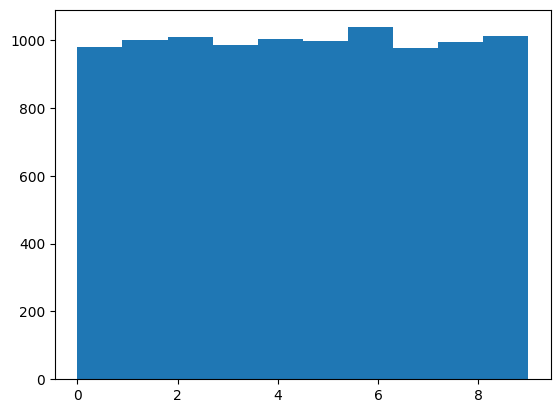

In [11]:
import matplotlib.pyplot as plt
results = [share_(secret=5, n=2) for _ in range(10000)]
plt.hist([r[0] for r in results], bins=10);

Sure enough, all results between 0 and 10 seem to be equally likely. The bars aren't identical because we've approximated the distribution of random shares by sampling 10000 times; if we increased the number of samples, the bars would get closer together.

This result is an example of *uniform randomness* - it's just like flipping a fair coin or rolling a fair 6-sided die. The graph would look the same no matter what `x` was - the first share doesn't reveal anything about `x`.

Let's see if the same thing is true for the second share:

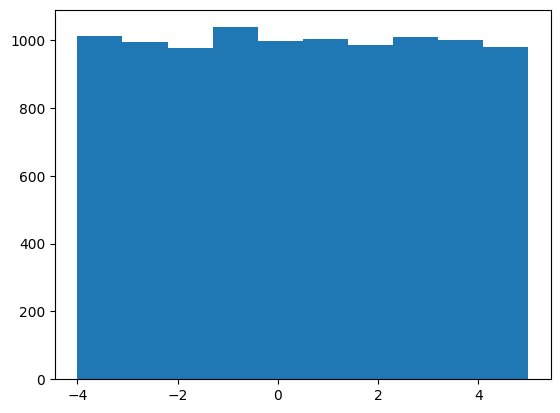

In [12]:
plt.hist([r[1] for r in results], bins=10);

This graph has a similar shape, but the maximum and minimum are different - there are no results smaller than -5, and there are lots of results bigger than 10. Unfortunately, this is a sign that the second share - by itself - can sometimes reveal something about `x`.

For example, if the second share's value is 15, then `x` *must have been* at least 5 - since the first share was between -10 and 10, any secret smaller than 5 would make it impossible for the second share to be 15.

This is a major security flaw, since neither share by itself is supposed to reveal anything about `x`. To fix this problem, we could use larger bounds than -10 and 10, which might make it harder to observe one of the problematic cases - but no matter how large we make the bounds, the same kind of leeakage is possible at the extreme values.

# Application: Counting Heart Disease Patients

Imagine two hospitals collect data about their patients, and they would like to collaborate to determine the prevalence of heart disease in the population. However, the hospitals are not willing to share their individual patient datasets with one another, since this could compromise the privacy of their patients. Instead, they would like to use a secure summation protocol to discover the total number of patients with heart disease between both hospitals, revealing *only* the total number of patients in the population with heart disease.

We'll use the famous [heart disease dataset](https://archive.ics.uci.edu/dataset/45/heart+disease) available at the UCI Machine Learning Repository. For our purposes, we've split the dataset into two parts: `heart1.csv` contains the first hospital's data, and `heart2.csv` contains the second hospital's data. The `target` column of the dataset contains a 1 if the patient has heart disease, and a 0 otherwise. To implement the desired protocol, we can use the following plan:

1. Write a function `count_heart_disease_patients` to count how many patients have heart disease
2. Have each hospital load their data and run the function on it to count their patients with heart disease
3. Run `secure_sum` between the hospitals to calculate the total number of patients with heart disease

The program below implements this plan.

In [13]:
import pandas as pd

In [14]:
GF = galois.GF(2**31-1)

# Step 1: a function to count the number of patients with heart disease
@pychor.local_function
def count_heart_disease_patients(df):
    return len(df[df['target'] == 1])

with pychor.LocalBackend():
    # Step 2: load data and count the number of patients with heart disease
    df1 = pychor.locally(pd.read_csv, 'heart1.csv'@p1)
    df2 = pychor.locally(pd.read_csv, 'heart2.csv'@p2)

    count1 = count_heart_disease_patients(df1)
    count2 = count_heart_disease_patients(df2)

    # Step 3: run the secure sum protocol
    total = secure_sum(count1, count2)

    print('Total number of patients with heart disease:', total)

Total number of patients with heart disease: 112@{p2, p1}


# Application: Average Age of Heart Disease Patients

In the next stage of their study, the two hospitals would like to know the average age of patients with heart disease, and the average age of patients without heart disease. The formula for computing the average is:

$$ \frac{\sum_{i=0}^n \textit{age}_i}{n} $$

where $n$ is the total number of patients. Unfortunately, this formula has division in it - and we don't have a way to perform division over secret-shared values!

Instead, we can build a more complicated protocol that reveals the numerator and denominator of this formula to both hospitals, and then compute the quotient as a post-processing step. This reveals the total number of heart disease patients across both hospitals, which is strictly more information than the quotient by itself. However, our previous step already revealed this value, so we won't worry about it in this case. We'll need to implement more complicated protocols to avoid revealing this information.

In [15]:
@pychor.local_function
def sum_age_heart_disease_patients(df):
    return df[df['target'] == 1]['age'].sum()

with pychor.LocalBackend():
    df1 = pychor.locally(pd.read_csv, 'heart1.csv'@p1)
    df2 = pychor.locally(pd.read_csv, 'heart2.csv'@p2)

    # Numerator: compute the total sum of all ages of heart disease patients
    sum1 = sum_age_heart_disease_patients(df1)
    sum2 = sum_age_heart_disease_patients(df2)

    total_sum = secure_sum(sum1, sum2)

    # Denominator: compute the total number of heart disease patients
    count1 = count_heart_disease_patients(df1)
    count2 = count_heart_disease_patients(df2)

    total_count = secure_sum(count1, count2)

    sum_int = pychor.locally(int, total_sum)
    count_int = pychor.locally(int, total_count)

    print('Average age of patients with heart disease:', sum_int / count_int)

Average age of patients with heart disease: 52.25@{p2, p1}


Note that we convert the total sum and count from field elements to integers before performing the division. Division of field elements doesn't have the same meaning, and won't give us the right answer.